In [1]:
#内置图像
%matplotlib inline
#加载R调用工具
%load_ext rpy2.ipython

In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

# 3.1获取数据

这里选择具有周期性的数据

In [3]:
dta=[10930,10318,10595,10972,7706,6756,9092,10551,9722,10913,11151,8186,6422, 
6337,11649,11652,10310,12043,7937,6476,9662,9570,9981,9331,9449,6773,6304,9355, 
10477,10148,10395,11261,8713,7299,10424,10795,11069,11602,11427,9095,7707,10767, 
12136,12812,12006,12528,10329,7818,11719,11683,12603,11495,13670,11337,10232, 
13261,13230,15535,16837,19598,14823,11622,19391,18177,19994,14723,15694,13248, 
9543,12872,13101,15053,12619,13749,10228,9725,14729,12518,14564,15085,14722, 
11999,9390,13481,14795,15845,15271,14686,11054,10395]

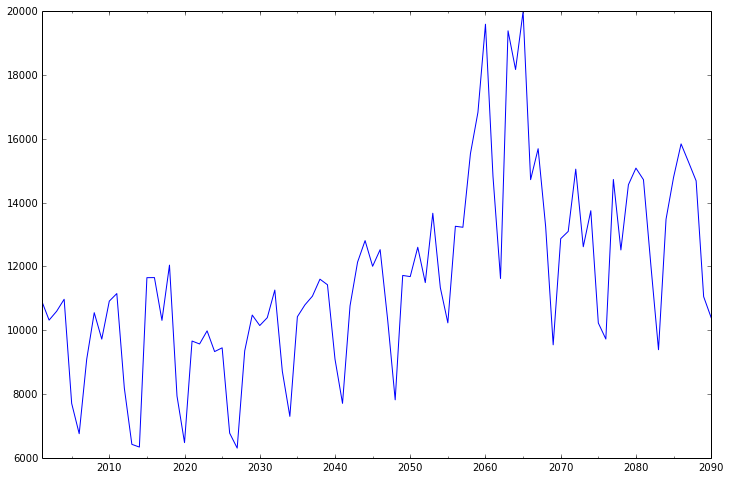

In [4]:
dta=pd.Series(dta)
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('2001','2090'))
dta.plot(figsize=(12,8))

# 3.2时间序列的差分d
ARIMA模型对时间序列的要求是平稳型，当遇到一个非平稳的时间序列时，需要做时间序列的差分，直到得到一个平稳的时间序列，如果做了d次差分才能得到一个平稳的序列，那么可以使用ARIMA(p,d,q)模型，其中d是差分次数

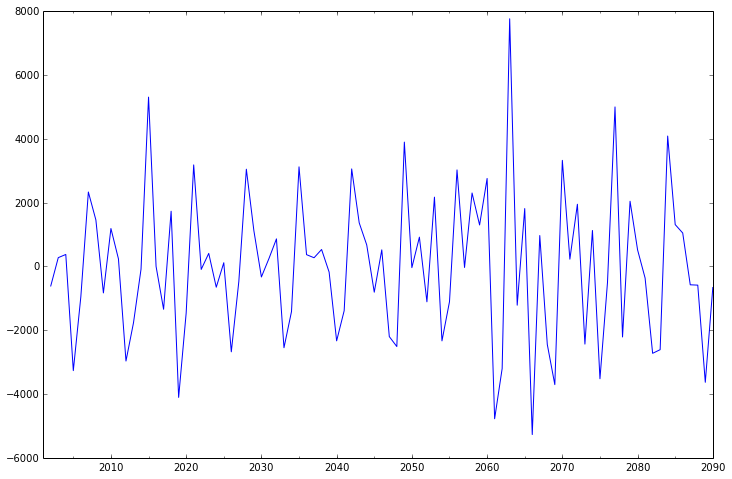

In [5]:
#一阶差分
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(111)
diff1 = dta.diff(1)
diff1.plot(ax = ax1)

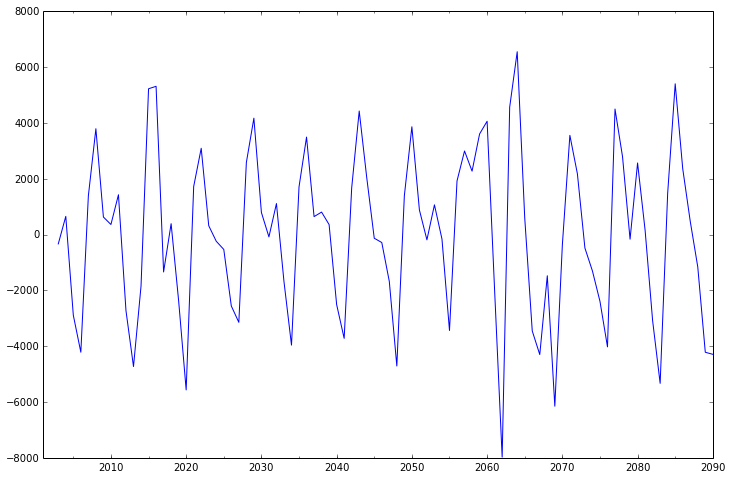

In [6]:
#二阶差分
fig = plt.figure(figsize = (12,8))
ax2 = fig.add_subplot(111)
diff2 = dta.diff(2)
diff2.plot(ax = ax2)

一阶差分和二阶差分区别不大，并且随着时间推移，时间序列的均值和方差保持不变，因此可以将差分次数d设置为1

# 3.3合适的p,q

现在得到了一个平稳的时间序列，接下来选择合适的ARIMA模型，即ARIMA模型中合适的p,q

第一步：先检查平稳时间序列的自相关图和偏自相关图

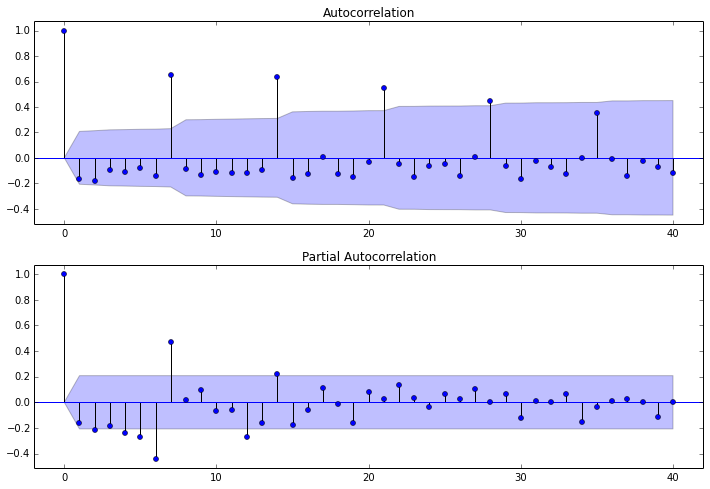

In [7]:
#lags为滞后的阶数ax1为acf,ax2为pacf
dta= dta.diff(1)#我们已经知道要使用一阶差分的时间序列，之前判断差分的程序可以注释掉
dta = dta[1:]#去掉重复的值
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=40,ax=ax2)

通过两图观察得到： 
* 自相关图显示滞后有三个阶超出了置信边界； 
* 偏相关图显示在滞后1至7阶（lags 1,2,…，7）时的偏自相关系数超出了置信边界，从lag 7之后偏自相关系数值缩小至0 
则有以下模型可以供选择： 
1. ARMA(0,1)模型：即自相关图在滞后1阶之后缩小为0，且偏自相关缩小至0，则是一个阶数q=1的移动平均模型； 
2. ARMA(7,0)模型：即偏自相关图在滞后7阶之后缩小为0，且自相关缩小至0，则是一个阶层p=3的自回归模型； 
3. ARMA(7,1)模型：即使得自相关和偏自相关都缩小至零。则是一个混合模型。 
4. …还可以有其他供选择的模型 
现在有以上这么多可供选择的模型，我们通常采用ARMA模型的AIC法则。我们知道：增加自由参数的数目提高了拟合的优良性，AIC鼓励数据拟合的优良性但是尽量避免出现过度拟合(Overfitting)的情况。所以优先考虑的模型应是AIC值最小的那一个。赤池信息准则的方法是寻找可以最好地解释数据但包含最少自由参数的模型。不仅仅包括AIC准则，目前选择模型常用如下准则： 
* AIC=-2 ln(L) + 2 k 中文名字：赤池信息量 akaike information criterion 
* BIC=-2 ln(L) + ln(n)*k 中文名字：贝叶斯信息量 bayesian information criterion 
* HQ=-2 ln(L) + ln(ln(n))*k hannan-quinn criterion 
构造这些统计量所遵循的统计思想是一致的，就是在考虑拟合残差的同时，依自变量个数施加“惩罚”。但要注意的是，这些准则不能说明某一个模型的精确度，也即是说，对于三个模型Ａ，Ｂ，Ｃ，我们能够判断出Ｃ模型是最好的，但不能保证Ｃ模型能够很好地刻画数据，因为有可能三个模型都是糟糕的。

In [8]:
arma_mod20 = sm.tsa.ARMA(dta,(7,0)).fit()
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)
arma_mod30 = sm.tsa.ARMA(dta,(0,1)).fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod50 = sm.tsa.ARMA(dta,(8,0)).fit()
print(arma_mod50.aic,arma_mod50.bic,arma_mod50.hqic)

1579.70255532 1602.10028265 1588.73043645
1632.32037316 1639.78628227 1635.32966687
1581.39578359 1606.28214729 1591.42676263


可以看到ARMA(7,0)的aic，bic，hqic均最小，因此是最佳模型。

# 3.4模型检验
在指数平滑模型下，观察ARIMA模型的残差是否是平均值为0且方差为常数的正态分布（服从零均值、方差不变的正态分布），同时也要观察连续残差是否（自）相关。

3.4.1我们对ARMA(7,0)模型所产生的残差做自相关图

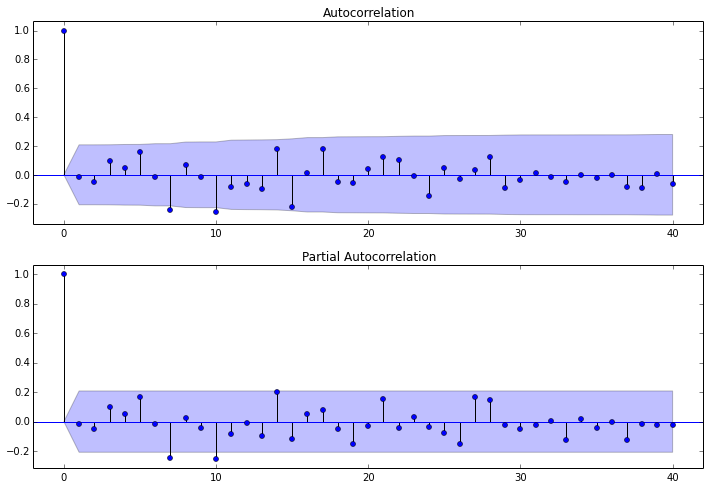

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_mod20.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_mod20.resid, lags=40, ax=ax2)

3.4.2做D-W检验

德宾-沃森（Durbin-Watson）检验。德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只使用于检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以 0≤DW≤４。并且DW＝0 ＝＞ρ＝１　　 即存在正自相关性 
DW＝４＜＝＞ρ＝－１　即存在负自相关性 
DW＝２＜＝＞ρ＝０　　即不存在（一阶）自相关性 
因此，当DW值显著的接近于0或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。这样只要知道ＤＷ统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设Ｈ０进行检验。

In [ ]:
print(sm.stats.durbin_watson(arma_mod20.resid.values))

检验结果是2.02424743723，说明不存在自相关性。

3.4.3观察是否符合正态分布

这里使用QQ图，它用于直观验证一组数据是否来着某个分布，或验证某两组数据是否来自同一分布，通常用来检验数据是否来自正态分布。

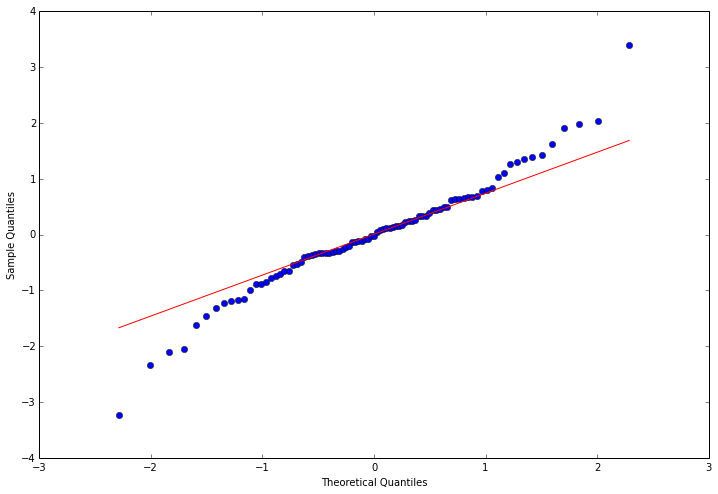

In [10]:
resid = arma_mod20.resid #残差
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid,line='q',ax=ax,fit=True)

3.4.4Ljung-Box检验

Ljung-Box test是对randomness的检验,或者说是对时间序列是否存在滞后相关的一种统计检验。对于滞后相关的检验，我们常常采用的方法还包括计算ACF和PCAF并观察其图像，但是无论是ACF还是PACF都仅仅考虑是否存在某一特定滞后阶数的相关。LB检验则是基于一系列滞后阶数，判断序列总体的相关性或者说随机性是否存在。

时间序列中一个最基本的模型就是高斯白噪声序列。而对于ARIMA模型，其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。

In [11]:
r,q,p = sm.tsa.acf(resid.values.squeeze(),qstat=True)
data = np.c_[range(1,41),r[1:],q,p]
table = pd.DataFrame(data,columns=['lag',"AC","Q","Prob(>Q)"])
print(table.set_index('lag'))

           AC          Q  Prob(>Q)
lag                               
1   -0.014448   0.019210  0.889765
2   -0.047438   0.228704  0.891944
3    0.097779   1.129075  0.770060
4    0.047513   1.344177  0.853837
5    0.156219   3.697155  0.593787
6   -0.017855   3.728263  0.713394
7   -0.241226   9.475572  0.220290
8    0.068074   9.938918  0.269339
9   -0.012042   9.953598  0.354255
10  -0.256685  16.708260  0.081074
11  -0.085178  17.461595  0.094944
12  -0.063576  17.886736  0.119173
13  -0.096514  18.879400  0.126891
14   0.181123  22.421979  0.070350
15  -0.223098  27.869386  0.022401
16   0.012916  27.887895  0.032608
17   0.176768  31.402730  0.017833
18  -0.053139  31.724839  0.023694
19  -0.057704  32.110089  0.030374
20   0.037423  32.274472  0.040460
21   0.120521  34.004481  0.036199
22   0.102659  35.278427  0.036226
23  -0.007830  35.285951  0.048711
24  -0.148547  38.035389  0.034384
25   0.046255  38.306139  0.043174
26  -0.032621  38.442939  0.055057
27   0.032380  38.57

检验的结果就是看最后一列前十二行的检验概率（一般观察滞后1~12阶），如果检验概率小于给定的显著性水平，比如0.05、0.10等就拒绝原假设，其原假设是相关系数为零。就结果来看，如果取显著性水平为0.05，那么相关系数与零没有显著差异，即为白噪声序列。

# 3.5模型预测
模型确定之后，就可以开始进行预测了，我们对未来十年的数据进行预测。

2090-12-31   -1235.954480
2091-12-31    3549.067449
2092-12-31    1236.730249
2093-12-31     649.971009
2094-12-31    -530.511098
2095-12-31    -611.679949
2096-12-31   -2290.186997
2097-12-31    -726.431914
2098-12-31    2740.895306
2099-12-31     953.042472
2100-12-31     277.240010
Freq: A-DEC, dtype: float64


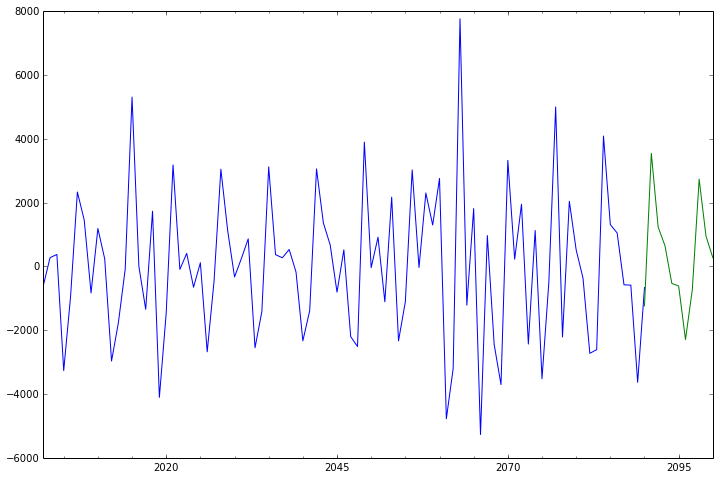

In [13]:
predict_sunspots = arma_mod20.predict('2090','2100',dynamic=True)
print(predict_sunspots)
fig,ax = plt.subplots(figsize=(12, 8))
ax = dta.ix['2001':].plot(ax=ax)
predict_sunspots.plot(ax=ax)

前面90个数据为测试数据，最后10个为预测数据；从图形来，预测结果较为合理。